https://zhuanlan.zhihu.com/p/435945714

In [1]:
import torch
from torch import nn, Tensor, optim
from torch.nn import functional as F
from torch_geometric import nn as gnn
from torch_geometric import datasets
from torch_geometric.data import Data, Dataset
from torch_geometric.loader import DataLoader, ClusterData, ClusterLoader
from torch_geometric import transforms as gtransforms
from torch_geometric.utils import to_networkx
import networkx as nx
from tqdm import tqdm
from plotly import express as px
from plotly import graph_objects as go
import matplotlib.pyplot as plt

In [2]:
device = (
    "cuda:0"
    if torch.cuda.is_available()
    else ("mps" if torch.backends.mps.is_available() else "cpu")
)
device

'cuda:0'

In [3]:
seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# torch_geometric.data.Data

节点和节点之间的边构成了图。所以在 PyG 中，如果你要构建图，那么需要两个要素：节点和边。PyG 提供了torch_geometric.data.Data (下面简称Data) 用于构建图，包括 5 个属性，每一个属性都不是必须的，可以为空。

- x: 用于存储每个节点的特征，形状是 `[num_nodes, num_node_features]`
- y: 存储样本标签。如果是每个节点都有标签，那么形状是 `[num_nodes, *]`；如果是整张图只有一个标签，那么形状是 `[1, *]`
- edge_index: 用于存储节点之间的边，形状是 `[2, num_edges]`
- pos: 存储节点的坐标，形状是 `[num_nodes, num_dimensions]`
- edge_attr: 存储边的特征。形状是 `[num_edges, num_edge_features]`

In [4]:
# x: 用于存储每个节点的特征，形状是 `[num_nodes, num_node_features]`。
x = torch.tensor([[2, 1], [5, 6], [3, 7], [12, 0]], dtype=torch.float)
x

tensor([[ 2.,  1.],
        [ 5.,  6.],
        [ 3.,  7.],
        [12.,  0.]])

In [5]:
# y: 存储样本标签。如果是每个节点都有标签，那么形状是 `[num_nodes, *]`；如果是整张图只有一个标签，那么形状是 `[1, *]`。
y = torch.tensor([[0], [2], [3], [4]], dtype=torch.long)
y

tensor([[0],
        [2],
        [3],
        [4]])

In [6]:
# edge_index: 用于存储节点之间的边，形状是 `[2, num_edges]`
# 5条边: (0 -> 1), (0 -> 2), (1 -> 2), (1 -> 3), (2 -> 3)
edge_index = torch.tensor(
    [[0, 1, 0, 1, 1, 2, 3], [1, 0, 2, 2, 3, 3, 2]], dtype=torch.long
)
edge_index

tensor([[0, 1, 0, 1, 1, 2, 3],
        [1, 0, 2, 2, 3, 3, 2]])

In [7]:
data = Data(x=x, y=y, edge_index=edge_index)
data

Data(x=[4, 2], edge_index=[2, 7], y=[4, 1])

In [8]:
for i in data:
    print(i)

('x', tensor([[ 2.,  1.],
        [ 5.,  6.],
        [ 3.,  7.],
        [12.,  0.]]))
('edge_index', tensor([[0, 1, 0, 1, 1, 2, 3],
        [1, 0, 2, 2, 3, 3, 2]]))
('y', tensor([[0],
        [2],
        [3],
        [4]]))


In [9]:
def visualize_graph(G, color):
    plt.figure(figsize=(7, 7))
    plt.xticks([])
    plt.yticks([])
    nx.draw_networkx(
        G,
        pos=nx.spring_layout(G, seed=42),
        with_labels=False,
        node_color=color,
        cmap="Set2",
    )
    plt.show()

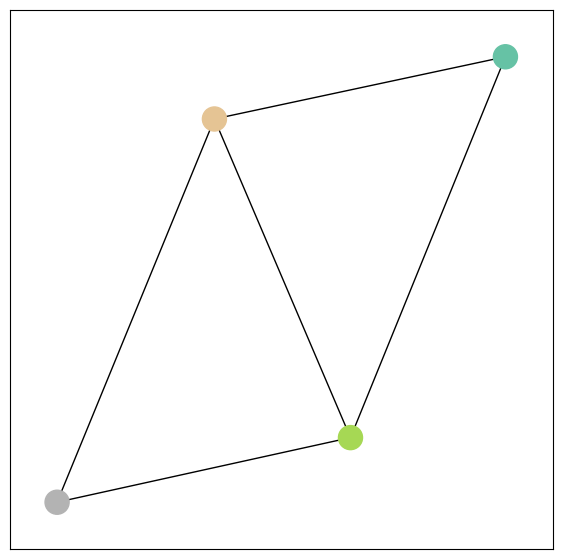

In [10]:
visualize_graph(to_networkx(data, to_undirected=True), color=data.y)

# from torch_geometric.datasets

In [11]:
transform = gtransforms.Compose(
    [
        gtransforms.ToUndirected(merge=False),
        # gtransforms.NormalizeFeatures(),
    ]
)
transform

Compose([
  ToUndirected()
])

| Name          | #graphs | #nodes | #edges  | #features | #classes |
| ------------- | ------- | ------ | ------- | --------- | -------- |
| MUTAG         | 188     | ~17.9  | ~39.6   | 7         | 2        |
| ENZYMES       | 600     | ~32.6  | ~124.3  | 3         | 6        |
| PROTEINS      | 1,113   | ~39.1  | ~145.6  | 3         | 2        |
| COLLAB        | 5,000   | ~74.5  | ~4914.4 | 0         | 3        |
| IMDB-BINARY   | 1,000   | ~19.8  | ~193.1  | 0         | 2        |
| REDDIT-BINARY | 2,000   | ~429.6 | ~995.5  | 0         | 2        |

In [13]:
dataset = datasets.OGB_MAG(
    root="./datasets/OGB",
    preprocess="metapath2vec",
    transform=transform,
)
dataset[0]

HeteroData(
  paper={
    x=[736389, 128],
    year=[736389],
    y=[736389],
    train_mask=[736389],
    val_mask=[736389],
    test_mask=[736389],
  },
  author={ x=[1134649, 128] },
  institution={ x=[8740, 128] },
  field_of_study={ x=[59965, 128] },
  (author, affiliated_with, institution)={ edge_index=[2, 1043998] },
  (author, writes, paper)={ edge_index=[2, 7145660] },
  (paper, cites, paper)={ edge_index=[2, 5416271] },
  (paper, has_topic, field_of_study)={ edge_index=[2, 7505078] },
  (institution, rev_affiliated_with, author)={ edge_index=[2, 1043998] },
  (paper, rev_writes, author)={ edge_index=[2, 7145660] },
  (paper, rev_cites, paper)={ edge_index=[2, 5416271] },
  (field_of_study, rev_has_topic, paper)={ edge_index=[2, 7505078] }
)

In [14]:
dataset = dataset.shuffle()
dataset[0]

HeteroData(
  paper={
    x=[736389, 128],
    year=[736389],
    y=[736389],
    train_mask=[736389],
    val_mask=[736389],
    test_mask=[736389],
  },
  author={ x=[1134649, 128] },
  institution={ x=[8740, 128] },
  field_of_study={ x=[59965, 128] },
  (author, affiliated_with, institution)={ edge_index=[2, 1043998] },
  (author, writes, paper)={ edge_index=[2, 7145660] },
  (paper, cites, paper)={ edge_index=[2, 5416271] },
  (paper, has_topic, field_of_study)={ edge_index=[2, 7505078] },
  (institution, rev_affiliated_with, author)={ edge_index=[2, 1043998] },
  (paper, rev_writes, author)={ edge_index=[2, 7145660] },
  (paper, rev_cites, paper)={ edge_index=[2, 5416271] },
  (field_of_study, rev_has_topic, paper)={ edge_index=[2, 7505078] }
)

In [15]:
dataset.num_edge_features

{('author', 'affiliated_with', 'institution'): 0,
 ('author', 'writes', 'paper'): 0,
 ('paper', 'cites', 'paper'): 0,
 ('paper', 'has_topic', 'field_of_study'): 0,
 ('institution', 'rev_affiliated_with', 'author'): 0,
 ('paper', 'rev_writes', 'author'): 0,
 ('paper', 'rev_cites', 'paper'): 0,
 ('field_of_study', 'rev_has_topic', 'paper'): 0}

In [16]:
dataset.num_node_features

{'paper': 128, 'author': 128, 'institution': 128, 'field_of_study': 128}

In [17]:
dataset.num_features, dataset.num_classes

({'paper': 128, 'author': 128, 'institution': 128, 'field_of_study': 128}, 349)

In [18]:
type(dataset), type(dataset[0])

(torch_geometric.datasets.ogb_mag.OGB_MAG,
 torch_geometric.data.hetero_data.HeteroData)

In [1]:
cluster_data = ClusterData(dataset[0], num_parts=128)  # 1. Create subgraphs.
train_dataloader = ClusterLoader(
    cluster_data, batch_size=32, shuffle=True
)  # 2. Stochastic partioning scheme.

NameError: name 'ClusterData' is not defined

In [20]:
for i, batch in enumerate(train_dataloader):
    print(batch)
    print(
        "x: \t\t", batch.x.shape
    )  # [batch_sum, num_features] 图的每一条数据的长度不一定相等,batch_sum代表这个batch中的全部节点数据
    print("edge_index: \t", batch.edge_index.shape)  # 代表边的连接
    print("y: \t\t", batch.y.shape)  # 类别
    print("y: \t\t", y)
    if i >= 5:
        break

NameError: name 'train_dataloader' is not defined

In [20]:
batch.x.shape

torch.Size([4932, 500])

# Model

In [46]:
class Net(nn.Module):
    def __init__(
        self,
        conv: nn.Module = gnn.GraphConv,  # [GraphConv, GCNConv, SAGEConv, GATConv]
        norm: nn.Module = nn.BatchNorm1d,  # [BatchNorm1d, LayerNorm, InstanceNorm1d]
        act: nn.Module = nn.ReLU,
    ) -> None:
        super().__init__()
        self.conv1 = conv(in_channels=dataset.num_features, out_channels=64)
        self.norm1 = norm(64)
        self.act1 = act()

        self.conv2 = conv(in_channels=64, out_channels=64)
        self.norm2 = norm(64)
        self.act2 = act()

        self.conv3 = conv(in_channels=64, out_channels=64)
        self.norm3 = norm(64)
        self.act3 = act()

        self.fc = nn.Linear(in_features=64, out_features=dataset.num_classes)

    def forward(self, x: Tensor, edge_index: Tensor, batch: Tensor = None) -> Tensor:
        x = self.conv1(x, edge_index)
        x = self.norm1(x)
        x = self.act1(x)

        res = x
        x = self.conv2(x, edge_index)
        x = self.norm2(x)
        x = self.act2(x)
        x = x + res

        res = x
        x = self.conv3(x, edge_index)
        x = self.norm3(x)
        x = self.act3(x)
        x = x + res

        # global_max_pool: 将节点嵌入聚合到一个统一的图嵌入(readout layer)中
        # x = gnn.global_max_pool(x, batch)   # [batch_sum, num_features] -> [batch, num_features]

        x = self.fc(x)
        return x

In [47]:
net = Net().to(device)
net

Net(
  (conv1): GraphConv(500, 64)
  (norm1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU()
  (conv2): GraphConv(64, 64)
  (norm2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act2): ReLU()
  (conv3): GraphConv(64, 64)
  (norm3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act3): ReLU()
  (fc): Linear(in_features=64, out_features=3, bias=True)
)

In [48]:
optimizer = optim.Adam(params=net.parameters())
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [49]:
epochs = 100

In [50]:
lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer=optimizer,
    T_max=epochs,
    eta_min=optimizer.state_dict()["param_groups"][0]["lr"] * 0.01,
)
lr_scheduler

In [51]:
loss_fn = nn.CrossEntropyLoss()
loss_fn

CrossEntropyLoss()

# train

In [52]:
train_accuracies = []
train_lossess = []
val_accuracies = []
val_lossess = []
for epoch in range(1, epochs + 1):
    net.train()
    train_y_trues = []
    train_y_preds = []
    train_losses = []
    pbar = tqdm(total=len(train_dataloader), desc=f"train-epoch: {epoch}")
    for batch in train_dataloader:
        optimizer.zero_grad()
        x, edge_index, y = batch.x, batch.edge_index, batch.y
        x, edge_index, y = x.to(device), edge_index.to(device), y.to(device)
        y_pred = net(x, edge_index, batch)
        loss: Tensor = loss_fn(y_pred, y)
        loss.backward()
        optimizer.step()

        train_y_trues.append(y)
        train_y_preds.append(y_pred.argmax(dim=-1))
        train_losses.append(loss.item())
        pbar.update(1)
        pbar.set_postfix({"loss": loss.item()})
    pbar.close()

    lr_scheduler.step()

    # 准确率
    train_y_trues_ = torch.cat(train_y_trues)
    train_y_preds_ = torch.cat(train_y_preds)
    train_accuracy = (
        (train_y_trues_ == train_y_preds_).float().sum().divide(len(train_y_trues_))
    )
    train_accuracies.append(train_accuracy.item())
    train_lossess.append(torch.tensor(train_losses).mean().item())

    # net.eval()
    # val_y_trues = []
    # val_y_preds = []
    # val_losses  = []
    # pbar = tqdm(total=len(val_dataloader), desc=f"val-epoch: {epoch}")
    # for batch in val_dataloader:
    #     x, edge_index, batch, y = batch.x, batch.edge_index, batch.batch, batch.y
    #     x, edge_index, batch, y = x.to(device), edge_index.to(device), batch.to(device), y.to(device)
    #     with torch.inference_mode():
    #         y_pred = net(x, edge_index, batch)
    #     loss: Tensor = loss_fn(y_pred, y)

    #     val_y_trues.append(y)
    #     val_y_preds.append(y_pred.argmax(dim=-1))
    #     val_losses.append(loss.item())
    #     pbar.update(1)
    #     pbar.set_postfix({"loss": loss.item()})
    # pbar.close()

    # # 准确率
    # val_y_trues_ = torch.cat(val_y_trues)
    # val_y_preds_ = torch.cat(val_y_preds)
    # val_accuracy = (val_y_trues_ == val_y_preds_).float().sum().divide(len(val_y_trues_))
    # val_accuracies.append(val_accuracy.item())
    # val_lossess.append(torch.tensor(val_losses).mean().item())

    print(
        f"\033[0;31;40mepoch: {epoch}\033[0m "
        + f"\033[0;32;40mtrain_accuracy = {train_accuracy.item()}\033[0m "
    )

train-epoch: 1: 100%|██████████| 4/4 [00:00<00:00,  6.29it/s, loss=0.943]


epoch: 1 train_accuracy = 0.5020540952682495 


train-epoch: 2: 100%|██████████| 4/4 [00:00<00:00, 62.92it/s, loss=0.765]


epoch: 2 train_accuracy = 0.7355581521987915 


train-epoch: 3: 100%|██████████| 4/4 [00:00<00:00, 59.00it/s, loss=0.727]


epoch: 3 train_accuracy = 0.7704519033432007 


train-epoch: 4: 100%|██████████| 4/4 [00:00<00:00, 62.50it/s, loss=0.587]


epoch: 4 train_accuracy = 0.7994623780250549 


train-epoch: 5: 100%|██████████| 4/4 [00:00<00:00, 57.96it/s, loss=0.538]


epoch: 5 train_accuracy = 0.8246183395385742 


train-epoch: 6: 100%|██████████| 4/4 [00:00<00:00, 60.61it/s, loss=0.422]


epoch: 6 train_accuracy = 0.836841344833374 


train-epoch: 7: 100%|██████████| 4/4 [00:00<00:00, 61.03it/s, loss=0.455]


epoch: 7 train_accuracy = 0.8418623805046082 


train-epoch: 8: 100%|██████████| 4/4 [00:00<00:00, 63.49it/s, loss=0.494]


epoch: 8 train_accuracy = 0.8392757773399353 


train-epoch: 9: 100%|██████████| 4/4 [00:00<00:00, 60.46it/s, loss=0.379]


epoch: 9 train_accuracy = 0.8517522811889648 


train-epoch: 10: 100%|██████████| 4/4 [00:00<00:00, 66.74it/s, loss=0.397]


epoch: 10 train_accuracy = 0.8592585325241089 


train-epoch: 11: 100%|██████████| 4/4 [00:00<00:00, 68.97it/s, loss=0.418]


epoch: 11 train_accuracy = 0.8581934571266174 


train-epoch: 12: 100%|██████████| 4/4 [00:00<00:00, 65.02it/s, loss=0.325]


epoch: 12 train_accuracy = 0.8703656792640686 


train-epoch: 13: 100%|██████████| 4/4 [00:00<00:00, 62.89it/s, loss=0.334]


epoch: 13 train_accuracy = 0.8782776594161987 


train-epoch: 14: 100%|██████████| 4/4 [00:00<00:00, 67.80it/s, loss=0.323]


epoch: 14 train_accuracy = 0.8745752573013306 


train-epoch: 15: 100%|██████████| 4/4 [00:00<00:00, 62.50it/s, loss=0.306]


epoch: 15 train_accuracy = 0.8836537003517151 


train-epoch: 16: 100%|██████████| 4/4 [00:00<00:00, 61.38it/s, loss=0.296]


epoch: 16 train_accuracy = 0.8891312479972839 


train-epoch: 17: 100%|██████████| 4/4 [00:00<00:00, 52.63it/s, loss=0.266]


epoch: 17 train_accuracy = 0.8955723643302917 


train-epoch: 18: 100%|██████████| 4/4 [00:00<00:00, 63.30it/s, loss=0.272]


epoch: 18 train_accuracy = 0.8987675905227661 


train-epoch: 19: 100%|██████████| 4/4 [00:00<00:00, 62.50it/s, loss=0.274]


epoch: 19 train_accuracy = 0.8894862532615662 


train-epoch: 20: 100%|██████████| 4/4 [00:00<00:00, 63.49it/s, loss=0.229]


epoch: 20 train_accuracy = 0.9062737822532654 


train-epoch: 21: 100%|██████████| 4/4 [00:00<00:00, 63.49it/s, loss=0.251]


epoch: 21 train_accuracy = 0.9094690084457397 


train-epoch: 22: 100%|██████████| 4/4 [00:00<00:00, 67.80it/s, loss=0.256]


epoch: 22 train_accuracy = 0.9097225666046143 


train-epoch: 23: 100%|██████████| 4/4 [00:00<00:00, 67.80it/s, loss=0.271]


epoch: 23 train_accuracy = 0.9125120639801025 


train-epoch: 24: 100%|██████████| 4/4 [00:00<00:00, 57.34it/s, loss=0.233]


epoch: 24 train_accuracy = 0.9169244766235352 


train-epoch: 25: 100%|██████████| 4/4 [00:00<00:00, 61.54it/s, loss=0.201]


epoch: 25 train_accuracy = 0.9144900441169739 


train-epoch: 26: 100%|██████████| 4/4 [00:00<00:00, 62.50it/s, loss=0.241]


epoch: 26 train_accuracy = 0.9238221049308777 


train-epoch: 27: 100%|██████████| 4/4 [00:00<00:00, 63.87it/s, loss=0.219]


epoch: 27 train_accuracy = 0.9261043667793274 


train-epoch: 28: 100%|██████████| 4/4 [00:00<00:00, 61.96it/s, loss=0.175]


epoch: 28 train_accuracy = 0.9208297729492188 


train-epoch: 29: 100%|██████████| 4/4 [00:00<00:00, 62.50it/s, loss=0.191]


epoch: 29 train_accuracy = 0.9275752305984497 


train-epoch: 30: 100%|██████████| 4/4 [00:00<00:00, 64.80it/s, loss=0.199]


epoch: 30 train_accuracy = 0.9303139448165894 


train-epoch: 31: 100%|██████████| 4/4 [00:00<00:00, 63.49it/s, loss=0.181]


epoch: 31 train_accuracy = 0.9343206286430359 


train-epoch: 32: 100%|██████████| 4/4 [00:00<00:00, 63.49it/s, loss=0.236]


epoch: 32 train_accuracy = 0.9264594316482544 


train-epoch: 33: 100%|██████████| 4/4 [00:00<00:00, 64.52it/s, loss=0.189]


epoch: 33 train_accuracy = 0.9361464977264404 


train-epoch: 34: 100%|██████████| 4/4 [00:00<00:00, 67.80it/s, loss=0.17] 


epoch: 34 train_accuracy = 0.9402039051055908 


train-epoch: 35: 100%|██████████| 4/4 [00:00<00:00, 64.52it/s, loss=0.19] 


epoch: 35 train_accuracy = 0.9426383376121521 


train-epoch: 36: 100%|██████████| 4/4 [00:00<00:00, 64.52it/s, loss=0.267]


epoch: 36 train_accuracy = 0.933407723903656 


train-epoch: 37: 100%|██████████| 4/4 [00:00<00:00, 64.51it/s, loss=0.144]


epoch: 37 train_accuracy = 0.9475579857826233 


train-epoch: 38: 100%|██████████| 4/4 [00:00<00:00, 64.52it/s, loss=0.19] 


epoch: 38 train_accuracy = 0.9439570307731628 


train-epoch: 39: 100%|██████████| 4/4 [00:00<00:00, 67.79it/s, loss=0.137]


epoch: 39 train_accuracy = 0.9490795135498047 


train-epoch: 40: 100%|██████████| 4/4 [00:00<00:00, 63.49it/s, loss=0.182]


epoch: 40 train_accuracy = 0.9390373826026917 


train-epoch: 41: 100%|██████████| 4/4 [00:00<00:00, 67.80it/s, loss=0.18] 


epoch: 41 train_accuracy = 0.9490795135498047 


train-epoch: 42: 100%|██████████| 4/4 [00:00<00:00, 64.52it/s, loss=0.187]


epoch: 42 train_accuracy = 0.9318861961364746 


train-epoch: 43: 100%|██████████| 4/4 [00:00<00:00, 64.52it/s, loss=0.121]


epoch: 43 train_accuracy = 0.9521732926368713 


train-epoch: 44: 100%|██████████| 4/4 [00:00<00:00, 63.96it/s, loss=0.148]


epoch: 44 train_accuracy = 0.9562814235687256 


train-epoch: 45: 100%|██████████| 4/4 [00:00<00:00, 62.50it/s, loss=0.112]


epoch: 45 train_accuracy = 0.9555713534355164 


train-epoch: 46: 100%|██████████| 4/4 [00:00<00:00, 63.49it/s, loss=0.121] 


epoch: 46 train_accuracy = 0.9588679671287537 


train-epoch: 47: 100%|██████████| 4/4 [00:00<00:00, 65.57it/s, loss=0.148] 


epoch: 47 train_accuracy = 0.9605416655540466 


train-epoch: 48: 100%|██████████| 4/4 [00:00<00:00, 67.80it/s, loss=0.135] 


epoch: 48 train_accuracy = 0.9567885994911194 


train-epoch: 49: 100%|██████████| 4/4 [00:00<00:00, 63.49it/s, loss=0.143]


epoch: 49 train_accuracy = 0.9498909711837769 


train-epoch: 50: 100%|██████████| 4/4 [00:00<00:00, 54.05it/s, loss=0.0903]


epoch: 50 train_accuracy = 0.967946469783783 


train-epoch: 51: 100%|██████████| 4/4 [00:00<00:00, 54.05it/s, loss=0.0949]


epoch: 51 train_accuracy = 0.9671856760978699 


train-epoch: 52: 100%|██████████| 4/4 [00:00<00:00, 64.52it/s, loss=0.113] 


epoch: 52 train_accuracy = 0.9708373546600342 


train-epoch: 53: 100%|██████████| 4/4 [00:00<00:00, 58.83it/s, loss=0.138] 


epoch: 53 train_accuracy = 0.9622660875320435 


train-epoch: 54: 100%|██████████| 4/4 [00:00<00:00, 59.70it/s, loss=0.0875]


epoch: 54 train_accuracy = 0.9664249420166016 


train-epoch: 55: 100%|██████████| 4/4 [00:00<00:00, 58.82it/s, loss=0.0898]


epoch: 55 train_accuracy = 0.9719531536102295 


train-epoch: 56: 100%|██████████| 4/4 [00:00<00:00, 60.61it/s, loss=0.126] 


epoch: 56 train_accuracy = 0.9598823189735413 


train-epoch: 57: 100%|██████████| 4/4 [00:00<00:00, 64.52it/s, loss=0.0878]


epoch: 57 train_accuracy = 0.9724096059799194 


train-epoch: 58: 100%|██████████| 4/4 [00:00<00:00, 62.92it/s, loss=0.0965]


epoch: 58 train_accuracy = 0.9733225107192993 


train-epoch: 59: 100%|██████████| 4/4 [00:00<00:00, 61.54it/s, loss=0.0973]


epoch: 59 train_accuracy = 0.976771354675293 


train-epoch: 60: 100%|██████████| 4/4 [00:00<00:00, 64.52it/s, loss=0.115] 


epoch: 60 train_accuracy = 0.972206711769104 


train-epoch: 61: 100%|██████████| 4/4 [00:00<00:00, 54.79it/s, loss=0.0816]


epoch: 61 train_accuracy = 0.9746919274330139 


train-epoch: 62: 100%|██████████| 4/4 [00:00<00:00, 59.70it/s, loss=0.0773]


epoch: 62 train_accuracy = 0.9773799180984497 


train-epoch: 63: 100%|██████████| 4/4 [00:00<00:00, 63.49it/s, loss=0.0742]


epoch: 63 train_accuracy = 0.9814373254776001 


train-epoch: 64: 100%|██████████| 4/4 [00:00<00:00, 60.61it/s, loss=0.0879]


epoch: 64 train_accuracy = 0.9779885411262512 


train-epoch: 65: 100%|██████████| 4/4 [00:00<00:00, 63.49it/s, loss=0.0673]


epoch: 65 train_accuracy = 0.9814373254776001 


train-epoch: 66: 100%|██████████| 4/4 [00:00<00:00, 63.49it/s, loss=0.0912]


epoch: 66 train_accuracy = 0.9731196761131287 


train-epoch: 67: 100%|██████████| 4/4 [00:00<00:00, 60.61it/s, loss=0.0812]


epoch: 67 train_accuracy = 0.9824516773223877 


train-epoch: 68: 100%|██████████| 4/4 [00:00<00:00, 59.70it/s, loss=0.0771]


epoch: 68 train_accuracy = 0.9819952249526978 


train-epoch: 69: 100%|██████████| 4/4 [00:00<00:00, 65.57it/s, loss=0.0601]


epoch: 69 train_accuracy = 0.9855961799621582 


train-epoch: 70: 100%|██████████| 4/4 [00:00<00:00, 65.57it/s, loss=0.0724]


epoch: 70 train_accuracy = 0.9802708625793457 


train-epoch: 71: 100%|██████████| 4/4 [00:00<00:00, 55.56it/s, loss=0.0702]


epoch: 71 train_accuracy = 0.9827560186386108 


train-epoch: 72: 100%|██████████| 4/4 [00:00<00:00, 66.67it/s, loss=0.0617]


epoch: 72 train_accuracy = 0.9780899882316589 


train-epoch: 73: 100%|██████████| 4/4 [00:00<00:00, 61.96it/s, loss=0.0629]


epoch: 73 train_accuracy = 0.9837196469306946 


train-epoch: 74: 100%|██████████| 4/4 [00:00<00:00, 60.61it/s, loss=0.0547]


epoch: 74 train_accuracy = 0.9804229736328125 


train-epoch: 75: 100%|██████████| 4/4 [00:00<00:00, 62.50it/s, loss=0.0537]


epoch: 75 train_accuracy = 0.9877263307571411 


train-epoch: 76: 100%|██████████| 4/4 [00:00<00:00, 56.34it/s, loss=0.0522]


epoch: 76 train_accuracy = 0.9812852144241333 


train-epoch: 77: 100%|██████████| 4/4 [00:00<00:00, 61.94it/s, loss=0.085] 


epoch: 77 train_accuracy = 0.9825531244277954 


train-epoch: 78: 100%|██████████| 4/4 [00:00<00:00, 63.49it/s, loss=0.0702]


epoch: 78 train_accuracy = 0.9849368929862976 


train-epoch: 79: 100%|██████████| 4/4 [00:00<00:00, 57.97it/s, loss=0.0635]


epoch: 79 train_accuracy = 0.9856469035148621 


train-epoch: 80: 100%|██████████| 4/4 [00:00<00:00, 33.61it/s, loss=0.0627]


epoch: 80 train_accuracy = 0.9878785014152527 


train-epoch: 81: 100%|██████████| 4/4 [00:00<00:00, 53.33it/s, loss=0.0654]


epoch: 81 train_accuracy = 0.9822995662689209 


train-epoch: 82: 100%|██████████| 4/4 [00:00<00:00, 55.56it/s, loss=0.1]   


epoch: 82 train_accuracy = 0.980169415473938 


train-epoch: 83: 100%|██████████| 4/4 [00:00<00:00, 58.82it/s, loss=0.0565]


epoch: 83 train_accuracy = 0.9865091443061829 


train-epoch: 84: 100%|██████████| 4/4 [00:00<00:00, 57.14it/s, loss=0.0385]


epoch: 84 train_accuracy = 0.990312933921814 


train-epoch: 85: 100%|██████████| 4/4 [00:00<00:00, 40.82it/s, loss=0.0499]


epoch: 85 train_accuracy = 0.9868641495704651 


train-epoch: 86: 100%|██████████| 4/4 [00:00<00:00, 61.96it/s, loss=0.0431]


epoch: 86 train_accuracy = 0.9879292249679565 


train-epoch: 87: 100%|██████████| 4/4 [00:00<00:00, 57.14it/s, loss=0.0526]


epoch: 87 train_accuracy = 0.988994300365448 


train-epoch: 88: 100%|██████████| 4/4 [00:00<00:00, 56.34it/s, loss=0.054] 


epoch: 88 train_accuracy = 0.9880306720733643 


train-epoch: 89: 100%|██████████| 4/4 [00:00<00:00, 59.70it/s, loss=0.0477]


epoch: 89 train_accuracy = 0.985241174697876 


train-epoch: 90: 100%|██████████| 4/4 [00:00<00:00, 57.97it/s, loss=0.0639]


epoch: 90 train_accuracy = 0.9880813360214233 


train-epoch: 91: 100%|██████████| 4/4 [00:00<00:00, 50.63it/s, loss=0.0478]


epoch: 91 train_accuracy = 0.9896535873413086 


train-epoch: 92: 100%|██████████| 4/4 [00:00<00:00, 58.82it/s, loss=0.0607]


epoch: 92 train_accuracy = 0.9851904511451721 


train-epoch: 93: 100%|██████████| 4/4 [00:00<00:00, 63.49it/s, loss=0.0605]


epoch: 93 train_accuracy = 0.9853426218032837 


train-epoch: 94: 100%|██████████| 4/4 [00:00<00:00, 62.50it/s, loss=0.0523]


epoch: 94 train_accuracy = 0.9908201098442078 


train-epoch: 95: 100%|██████████| 4/4 [00:00<00:00, 56.34it/s, loss=0.147] 


epoch: 95 train_accuracy = 0.9749962091445923 


train-epoch: 96: 100%|██████████| 4/4 [00:00<00:00, 59.70it/s, loss=0.059] 


epoch: 96 train_accuracy = 0.9879292249679565 


train-epoch: 97: 100%|██████████| 4/4 [00:00<00:00, 51.95it/s, loss=0.0551]


epoch: 97 train_accuracy = 0.9911244511604309 


train-epoch: 98: 100%|██████████| 4/4 [00:00<00:00, 57.97it/s, loss=0.0413]


epoch: 98 train_accuracy = 0.9880306720733643 


train-epoch: 99: 100%|██████████| 4/4 [00:00<00:00, 60.61it/s, loss=0.0655]


epoch: 99 train_accuracy = 0.9846832752227783 


train-epoch: 100: 100%|██████████| 4/4 [00:00<00:00, 59.19it/s, loss=0.0836]

epoch: 100 train_accuracy = 0.981031596660614 


In [53]:
print(max(train_accuracies))
# 1.0 0.9729729890823364

0.9911244511604309


In [54]:
figure = go.Figure(
    data=[
        go.Scatter(
            y=train_accuracies,
            mode="lines+markers",
            name="train",
        ),
        # go.Scatter(
        #     y=val_accuracies,
        #     mode="lines+markers",
        #     name="val",
        # ),
    ]
)
figure.show()

In [55]:
figure = go.Figure(
    data=[
        go.Scatter(y=train_lossess, mode="lines+markers", name="train"),
        # go.Scatter(
        #     y=val_lossess,
        #     mode="lines+markers",
        #     name="val"
        # ),
    ]
)
figure.show()